In [577]:
import numpy as np
import requests
import re

from bs4 import BeautifulSoup

from nltk import sent_tokenize
from nltk import word_tokenize
from nltk import pos_tag
from nltk import PorterStemmer
from nltk.corpus import stopwords

from sklearn.cluster import KMeans, AffinityPropagation
from sklearn import metrics

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds as SVDS
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import distance_metrics 
from sklearn.metrics.pairwise import pairwise_distances
import seaborn as sns
import matplotlib.patheffects as PathEffects
from itertools import groupby, count
import matplotlib.pyplot as plt

%matplotlib inline




stop_words = stopwords.words('english')
def get_movie_soup(link):
    response = requests.get(link)
    movie_soup = BeautifulSoup(response.content, 'html.parser')
    return movie_soup

from collections import defaultdict, OrderedDict
string_list = ["FINN", "EXT. NIIMA OUTPOST - DAY", "I/E MARK'S FORD - DAY",
              "CUT TO:", "(to chewie)"]

def is_scene(string, tags=['INT.', 'EXT.', 'I/E', '-']):
    int_or_ext = [i in string.upper() for i in tags]
    return sum(int_or_ext) != 0

BEG_PARENS_REGEX = re.compile(r'\(')
def is_addressant(string):
    if BEG_PARENS_REGEX.match(string):
        return True
    else:
        return False


# for i in zip(string_list, map(is_scene, string_list)):
#     print "is scene?: ", i
# for i in zip(string_list, map(is_addressant, string_list)):
#     print "is addressant?: ", i

a = 'hello      high     how are you.  There.'
rey = "REY (CONT'D)"
han = "HAN (Continued)"
ext = "EXT. SOMETHING DARKSIDE"

WHT_SPC_REGEX = re.compile(r'\s{2,}')
def remove_long_white_space(string):
    new_string = WHT_SPC_REGEX.sub(' ', string)
    return new_string

PARENS_REGEX = re.compile(r'(\w{2,})+\s(.*)')
def remove_parens(string):
    if "(" in string:        
        new_string = PARENS_REGEX.sub(r'\1', string)
        return new_string
    else:
        return string


remove_parens(ext)

def get_movie_script(link):
    movie_soup = get_movie_soup(link)
    movie_text = movie_soup.findAll('pre')[0]
    return to_unicode_or_bust(str(movie_text))
# script = few_good_men.findAll('pre')[0]

def to_unicode_or_bust(
    obj, encoding='utf-8'):
    if isinstance(obj, basestring):
        if not isinstance(obj, unicode):
            obj = unicode(obj, encoding)
    return obj

def clean_text(text):
    bold_splits = text.split('<b>')

    character_docs = defaultdict(list)
    scene_docs = defaultdict(list)

    character_sents = []
    character_track = []

    current_scene = None
    prior_character = None
    missed_things = 0
    porter_stemmer = PorterStemmer()
    for slug in bold_splits:
        phrase = slug.strip().split('</b>')
        bold = phrase[0].strip()
        bold = remove_parens(bold)

        if is_scene(bold):
            current_scene = bold

        try:
            sentences = phrase[1].strip()        
            if not is_scene(bold):
                sentences_list = sent_tokenize(sentences, language="english")
                for sent in sentences_list:
                    sent_cleaned = sent.replace("\r\n", "")
                    sent_cleaned = remove_long_white_space(sent_cleaned)
                    sent_cleaned = sent_cleaned.lower()
                    current_character = bold
                    if is_addressant(bold):
                        current_character = prior_character

                    if sent_cleaned != None and current_scene != None\
                    and current_character != None:
                        sent_cleaned = sent_cleaned.split(" ")
                        sent_cleaned = " ".join(porter_stemmer.stem_word(word) for word in sent_cleaned)
#                         character_docs[current_character].append((
#                         " ".join([sent_cleaned, current_scene])))
                        character_docs[current_character].append((
                        " ".join([sent_cleaned, current_scene])))                        
    #                     character_sents.append((sent_cleaned, current_scene))
    #                     character_track.append(current_character)

                    prior_character = bold


        except IndexError:
            pass
            missed_things += 1
    return character_docs



def order_character_dict(dictionary):
    characters = dictionary.keys()
    for name in characters:
        for name_scan in characters:
            if name in name_scan and name != name_scan:
                dictionary[name] += dictionary[name_scan]
                dictionary[name_scan] = []

    ordered = OrderedDict(sorted(dictionary.items(), 
                                 key=lambda t: len(t[1]), 
                                 reverse=True))
    return ordered


def gen_char_tags(characters_to_analyze, character_docs):

    sentence_list = []
    char_tags = []
    for character in characters_to_analyze:
        for line in character_docs[character]:
            sentence_list.append(line)
            char_tags.append(character)
    return char_tags, sentence_list

def scatter(x, ch_label):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("muted", len(ch_label)))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[ch_label.astype(np.int)])
#     plt.xlim(-25, 25)
#     plt.ylim(-25, 25)
    plt.xlim(-.1, .1)
    plt.ylim(-.1, .1)
    plt.grid()
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in set(ch_label):
#         print CHARACTERS_TO_ANALYZE[i]
        xtext, ytext = np.median(x[ch_label == i, :], axis=0)
#         print "x is", x
#         print "ch_label is: ", ch_label
        txt = ax.text(xtext, ytext, CHARACTERS_TO_ANALYZE[i], fontsize=24, color=palette[i])
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
#     for char in 
    return f, ax, sc, txts

def plot_corr(input_clustered_ch_w_sent, filtered_characters):
    character_groups = []
    ch_uniquekeys = []
    clustered_ch_w_sent = [i for i in input_clustered_ch_w_sent if i[1] in filtered_characters]

    for i, label in groupby(clustered_ch_w_sent, lambda x: x[0]):
        local_labels = [i[1] for i in label]
    #     local_labels = Counter([i[1] for i in label])
        character_groups.append(local_labels)
        ch_uniquekeys.append(i)


    character_doc_vectorizer = TfidfVectorizer(norm='l1')
    ch_occurences = [" ".join(i) for i in character_groups]
    ch_x = character_doc_vectorizer.fit_transform(ch_occurences)
    ch_pairs = pairwise_distances(ch_x.T, metric='cosine') + .0001
    
    character_names = [i.upper() for i in character_doc_vectorizer.get_feature_names()]

    pair_dist = pdist(ch_x.T.toarray())
    v = squareform(pair_dist)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    labels = np.array(character_names)
    ax.matshow(v, cmap=plt.cm.gray)
    ax.set_xticks(range(len(character_names)))
    ax.set_yticks(range(len(character_names)))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels);

def cluster_docs(script):
    cluster_model = AffinityPropagation(affinity='precomputed', damping=.5)
    precomputed_script = pairwise_distances(script, metric='cosine') + .0001
    cluster_model.fit_predict(precomputed_script)
#     clustered_characters = sorted(zip(ac.labels_, CHAR_TAGS), key=lambda x: x[0])
    clustered_characters_w_sentence = sorted(zip(cluster_model.labels_, CHAR_TAGS, SENTENCE_LIST), key=lambda x: x[0])
    silh_score = metrics.silhouette_score(precomputed_script, cluster_model.labels_, metric='precomputed')
    return silh_score, cluster_model, clustered_characters_w_sentence

def fit_plot_tsne_cos(x):
    precomputed_x = pairwise_distances(x, metric='cosine') + .0001
    scripts_proj = TSNE(random_state=0, n_components=2, metric='precomputed').fit_transform(precomputed_x)
    char_convert_num = dict(enumerate(CHARACTERS_TO_ANALYZE))
    char_convert_num = {v: k for k, v in char_convert_num.items()}
    char_nums = np.array(map(lambda key: char_convert_num[key], CHAR_TAGS))
    return scripts_proj, char_nums

def filter_array(scripts_proj, char_nums, names_to_plot_list):
    filter_array = np.array(map(lambda x: bool(x in names_to_plot_list), CHAR_TAGS))
    filtered_char_nums = char_nums[filter_array]
    filtered_scripts_proj = scripts_proj[filter_array] 

    ### only plot these names though
    ### We only want to plot the indexes of scripts_proj and char_names that have
    ### The indexes of the desired characters.  
    ### 1. Get the indexes of the desired characters
    return filtered_scripts_proj, filtered_char_nums        
    

#### There's some cleaning up to be done for getting semi-unique character names better.  

*i.e. General Hux vs General 'something' would just yield two 'General' 's*

# Vectorize and SVD Per Character

Need to reduce for set of characters then cluster (then grab cosine similarity of the means of c

# SELECT CHARACTERS

# Cosine Similarity: TSNE then AffinityPropagation

### TSNE

# Wolf of Wall Street

In [578]:
# SCRIPT = get_movie_script('http://www.imsdb.com/scripts/A-Few-Good-Men.html')
# SCRIPT = get_movie_script('http://www.imsdb.com/scripts/Star-Wars-The-Force-Awakens.html')
# SCRIPT = get_movie_script('http://www.imsdb.com/scripts/I-Still-Know-What-You-Did-Last-Summer.html')
SCRIPT = get_movie_script("http://www.imsdb.com/scripts/Pride-and-Prejudice.html")
CHARACTER_DOCS = order_character_dict(
    clean_text(SCRIPT))
CHARACTERS_TO_ANALYZE = CHARACTER_DOCS.keys()
CHAR_TAGS, SENTENCE_LIST = gen_char_tags(CHARACTERS_TO_ANALYZE, CHARACTER_DOCS)
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)
TFIDF_SCRIPT = vectorizer.fit_transform(SENTENCE_LIST)

T,sigma,D_trans = SVDS(TFIDF_SCRIPT.toarray().T, k=5)
D = D_trans.T
scripts, char_nums = fit_plot_tsne_cos(D)

# Maybe try DBSCAN?  since the clusters aren't round and the number of clusters is unknown

# Definitely include the counts/relationship of characters as they appear in similar clusters.  

#### Select character

In [589]:
CHARACTERS_TO_ANALYZE[:30]

[u'ELIZABETH',
 u'MRS BENNET',
 u'DARCY',
 u'JANE',
 u'MR BENNET',
 u'LYDIA',
 u'LADY CATHERINE',
 u'\xc2\x80\xa2',
 u'CUT TO:',
 u'CHARLOTTE',
 u'WICKHAM',
 u'BINGLEY',
 u'MR COLLINS',
 u'CAROLINE BINGLEY',
 u'COLLINS',
 u'KITTY',
 u'MRS GARDINER',
 u'FITZWILLIAM',
 u'LIZZIE',
 u'MARY',
 u'MRS',
 u'MRS REYNOLDS',
 u'MR BINGLEY',
 u'(PAUSE)',
 u'MR GARDINER',
 u'PLAYING)',
 u'MISS BINGLEY',
 u'SIR WILLIAM',
 u'(TO',
 u'MRS HILL']

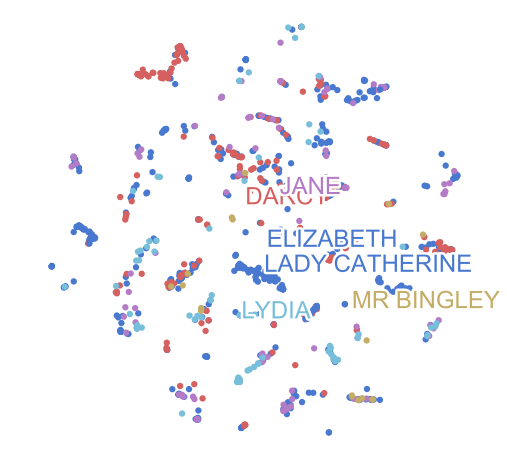

In [599]:
NAMES_TO_PLOT = ['ELIZABETH', 'JANE', 'DARCY', 'LADY CATHERINE', 'LYDIA', 'MR BINGLEY']

filtered_scripts, filtered_char_nums = filter_array(scripts, char_nums, NAMES_TO_PLOT)
scatter(filtered_scripts,filtered_char_nums);

In [582]:
silh_score, cluster_model, clustered_characters_w_sentence = cluster_docs(filtered_scripts)

In [583]:
silh_score

-0.32060376501786558

In [521]:
[i for i in clustered_characters_w_sentence if i[0] == 3]

[(3, 'FINN', 'i see it! INT. TIE FIGHTER - DAY'),
 (3,
  'FINN',
  'the flood tunnel are over that ridge. EXT. STARKILLER BASE - DAY'),
 (3, 'FINN', "we'll get in that way. EXT. STARKILLER BASE - DAY"),
 (3, 'FINN', 'sanitation. EXT. STARKILLER BASE - DAY'),
 (3, 'FINN', "i don't. EXT. STARKILLER BASE - DAY"),
 (3, 'FINN', "i'm just here to get rey. EXT. STARKILLER BASE - DAY"),
 (3, 'FINN', "solo, we'll figur it out! EXT. STARKILLER BASE - DAY"),
 (3, 'FINN', "we'll use the force! EXT. STARKILLER BASE - DAY"),
 (3, 'FINN', 'come on! EXT. STARKILLER BASE - DAY'),
 (3,
  'FINN',
  u'they follow finn on the snowi hike. EXT. STARKILLER BASE - DAY'),
 (3, 'FINN', 'on the horizon, the EXT. STARKILLER BASE - DAY'),
 (3,
  'FINN',
  u'finn and rey, overcom with emotion, race through the snowi forest -- until finn slow and stops. EXT. FOREST - NIGHT'),
 (3, 'FINN', 'rey stop too, both out of breath. EXT. FOREST - NIGHT'),
 (3, 'FINN', 'they look at each other. EXT. FOREST - NIGHT'),
 (3, 'FINN

In [597]:
a, b = fit_plot_tsne_cos(cluster_model.cluster_centers_indices_)

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: array must not contain infs or NaNs

In [598]:
cluster_model.cluster_centers_indices_.reshape()

(400,)

# Maybe in the future...

### Affinity Propagation

There's an unknown number of clusters so AffinityPropagation is appropriate. 

In [376]:
silh_score, cluster_model, clustered_ch_w_sent = cluster_docs(TFIDF_SCRIPT.toarray())
print silh_score

-0.086322024701


In [335]:
[x for x in clustered_ch_w_sent if x[0] == 100]

[(100, 'FINN', 'we need to get outta thi system! INT. TIE FIGHTER - DAY'),
 (100, 'FINN', "i'm in charg now, phasma. FN-2187."),
 (100,
  'FINN',
  'chewi moan/talks. INT. STARKILLER BASE - CONTROL ACCESS POINT - DAY'),
 (100, 'REY', 'bb-8 stay close! EXT. NIIMA OUTPOST - DAY'),
 (100, 'REY', 'huge! INT. CARGO SHIP - BELOW FLOOR GRATING - DAY'),
 (100, 'REY', 'i believ that. INT. RESISTANCE BASE - I.C.U. - DAY'),
 (100, 'POE', 'nice shot. INT. TIE FIGHTER - DAY'),
 (100, 'MAZ', "han solo! INT. MAZ'S CASTLE - MAIN ROOM - DAY")]

# After Reduction k=160 (plotting high dimension into 2D)

#### TSNE

In [353]:
T,sigma,D_trans = SVDS(TFIDF_SCRIPT.toarray().T, k=160)
D = D_trans.T

In [355]:
D_scripts, D_char_nums = fit_plot_tsne_cos(D)

(<matplotlib.figure.Figure at 0x112fd1950>,
  <matplotlib.text.Text at 0x112f590d0>])

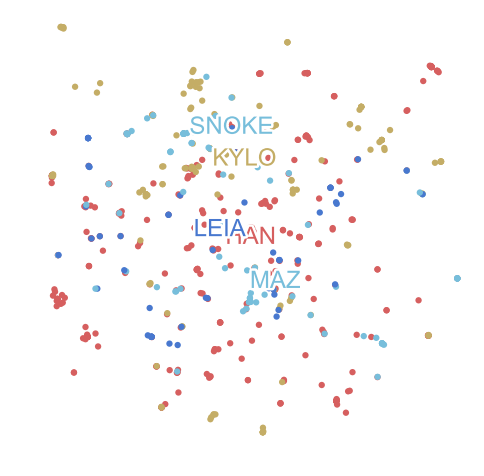

In [371]:
D_filtered_scripts, D_filtered_char_nums = filter_array(D_scripts, D_char_nums, ['LEIA', 'KYLO', 'HAN', 'SNOKE', 'MAZ'])
scatter(D_filtered_scripts, D_filtered_char_nums)


#### Affinity Propagation

In [357]:
silh_score, cluster_model, clustered_ch_w_sent = cluster_docs(D)

In [363]:
[x for x in clustered_ch_w_sent if x[0] == 100]

[(100, 'REY', 'she head off again. (BB-8 BEEPS)'),
 (100, 'REY', 'they head off together. (BB-8 BEEPS)'),
 (100, 'REY', 'come on. INT. NIIMA TRADING STRUCTURE - DAY'),
 (100, 'HAN', 'han head off as: INT. CARGO SHIP - HANGAR - DAY'),
 (100, 'MAZ', "everyon turn to look. INT. MAZ'S CASTLE - MAIN ROOM - DAY"),
 (100,
  'STORMTROOPER',
  'rey, finn and bb-8 duck into anoth tent: EXT. NIIMA OUTPOST - DAY'),
 (100,
  'UNKAR',
  'she swallow her resent and head off. INT. NIIMA TRADING STRUCTURE - DAY'),
 (100,
  'LIEUTENANT',
  'ren turn to look at him, he say nothing. INT. STAR DESTROYER BRIDGE - DAY'),
 (100,
  'NO!',
  "she turn to look -- we pivot -- and see a burn templ at night. INT. MAZ'S CASTLE - CRYPT ROOM - DAY")]